# X3D (eXpanded 3D) Implementation - Design Alternative 1

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error, sige ka magla-lag yang pc mo

`Note`: Isipin mo alternate universe na training toh

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


`Note`: This notebook's codes will come from [PytorchVideo](https://pytorchvideo.org/docs/tutorial_overview) and from this Talha Anwar's [YouTube Playlist](https://www.youtube.com/playlist?list=PLtGXgNsNHqPRAscIi6dMUuPCfDQ1Vho2U)

#### Import Libraries

In [1]:
import sys
sys.path.append('pytorchvideo')
import torchvision.transforms.functional as F_t

sys.modules["torchvision.transforms.functional_tensor"] = F_t
import pytorchvideo
from pytorchvideo.data import *
import pytorch_lightning
import torchmetrics
import torch

import pandas as pd
import pathlib
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name() # Check if GPU is available

(True, 'NVIDIA GeForce RTX 3070')

In [3]:
#pathlib.PosixPath = pathlib.WindowsPath # For windows only

#### Prepare the dataset

In [4]:
dataset_dir = "./Copy/PD_Dataset"

In [5]:
def renameFile():
    for file_path in pathlib.Path(dataset_dir).rglob("*.avi"):
        # Get the parent directory name and clean it up
        # Clean the file name by replacing spaces with underscores
        file_clean = file_path.name.replace(" ", "_")
        
        # Create the new file namev
        new_name = f"{file_clean}"
        new_path = file_path.parent / new_name
        
        print(f"Renaming: {file_path} -> {new_path}")
        file_path.rename(new_path)

In [6]:
#renameFile() #run once...

In [7]:
categories = sorted(["BarbellCurl", "Deadlift", "LateralRaises", "OverheadPress", "Squat"])

video_labels = [
    [video for video in (pathlib.Path(dataset_dir) / category).iterdir() if video.is_file()]
    for category in categories
]

# Flatten and create labels
label = [i for i, videos in enumerate(video_labels) for _ in videos]
combined = [video for sublist in video_labels for video in sublist]

print(label)
print(combined)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [8]:
df = pd.DataFrame(zip(combined, label), columns=["file", "label"])
df.head()

,file,label
0,Copy/PD_Dataset/BarbellCurl/[SHANA]VID_2025031...,0
1,Copy/PD_Dataset/BarbellCurl/[SHANA]VID_2025031...,0
2,Copy/PD_Dataset/BarbellCurl/[SHANA]VID_2025031...,0
3,Copy/PD_Dataset/BarbellCurl/[SHANA]VID_2025031...,0
4,Copy/PD_Dataset/BarbellCurl/[SHANA]VID_2025031...,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    764 non-null    object
 1   label   764 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ KB


In [10]:
df["label"].value_counts()

label
3    183
0    158
2    151
1    140
4    132
Name: count, dtype: int64

data is not balanced so... Remove tayo randomly :)

In [11]:
## Function to balance the dataset
def balance_dataset(df):
    min_count = df["label"].value_counts().min() # Find the minimum count among all classes
    
    # Downsample each class to match min_count
    balanced_df = (
        df.groupby("label").apply(lambda x: x.sample(n=min_count, random_state=0)).reset_index(drop=True)
    )
    
    return balanced_df

In [12]:
df = balance_dataset(df)
df["label"].value_counts() # Check for the number of data

/tmp/ipykernel_662761/1571708001.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("label").apply(lambda x: x.sample(n=min_count, random_state=0)).reset_index(drop=True)


label
0    132
1    132
2    132
3    132
4    132
Name: count, dtype: int64

What the function did was take the lowest count of data then removes random files from the dataframe

#### Split the dataset

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train_df, val_df = train_test_split(df, test_size=0.3, shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1, shuffle=False)

In [14]:
len(train_df), len(val_df), len(test_df)

(462, 178, 20)

In [15]:
train_df.to_csv("dataset20/train_df.csv", header=False , sep=" ", index=False) 
val_df.to_csv("dataset20/val_df.csv", header=False, sep=" ", index=False)
test_df.to_csv("dataset20/test_df.csv", header=False, sep=" ", index=False)

#### Prepare and augment the dataset for better generalization of the mudel 

In [16]:
clip_duration = 6
sub_clip_duration = 30
batch_size = 8
crop_size_min = 256
crop_size_max =  320
crop_size_final = 160
epoch = 50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..2.0784316].


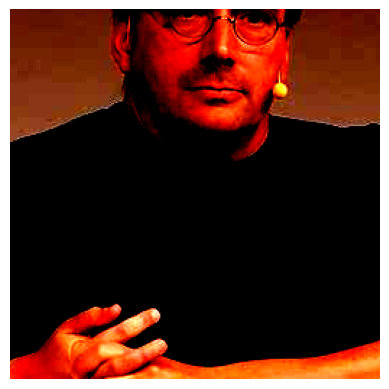

In [17]:
## Just to visualize what the frames would look like
from PIL import Image
from torchvision.transforms import *

def show_aug(img_pth: str):
    transform_pipeline = Compose([
        #RandomResizedCrop(crop_size_min),
        CenterCrop(crop_size_min),              
        RandomHorizontalFlip(p=0.5),             
        ToTensor(),                              
        Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225))  
    ])
    img = Image.open(img_pth).convert("RGB")
    img_tensor = transform_pipeline(img)
    if img_tensor.is_sparse:
        img_tensor = img_tensor.to_dense()
    return img_tensor

aug_tensor = show_aug("linus.jpg")

plt.imshow(aug_tensor.cpu().permute(1, 2, 0).numpy()) # Rearrange dimensions from (C, H, W) to (H, W, C) for matplotlib
plt.axis("off")
plt.show()

In [18]:
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    ShortSideScale,
    RandomShortSideScale,
    UniformTemporalSubsample,
    RandomResizedCrop,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomHorizontalFlip,
    RandomCrop,
    CenterCrop,
)

In [ ]:
class KineticsDataModule(pytorch_lightning.LightningDataModule):
  _DATA_PATH = "dataset20"
  _CLIP_DURATION = clip_duration  # Duration of sampled clip for each video
  _SUB_CLIP_DURATION = sub_clip_duration # Number of frames per second (FPS)
  _BATCH_SIZE = batch_size # Number of batches to train
  _CROP_SIZE_MIN = crop_size_min
  _CROP_SIZE_MAX = crop_size_max
  _CROP_SIZE_FINAL = crop_size_final # Last resize toh

  _NUM_WORKERS = 5  # Number of parallel processes fetching data, the higher the faster but do keep in mind of your processor specs
  _PIN_MEMORY = True

  def _video_transform(self, mode: str):
        transform_steps = [
            Lambda(lambda x: x / 255.0),
            UniformTemporalSubsample(self._SUB_CLIP_DURATION),
            Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
        ]

        if mode == "train":
            transform_steps += [
                RandomShortSideScale(min_size=self._CROP_SIZE_MIN, max_size=self._CROP_SIZE_MAX),
                RandomHorizontalFlip(p=0.5),
                CenterCrop(self._CROP_SIZE_FINAL), # This will be the final size of the frame
            ]
        else:
            transform_steps += [
                ShortSideScale(self._CROP_SIZE_FINAL),
                CenterCrop(self._CROP_SIZE_FINAL)
            ]

        return ApplyTransformToKey(
            key="video",
            transform=Compose(transform_steps)
        )


  def train_dataloader(self):
    """
    Create the Kinetics train partition from the list of video labels
    in {self._DATA_PATH}/train
    """

    train_dataset = labeled_video_dataset(
        data_path=os.path.join(self._DATA_PATH, "train_df.csv"),
        clip_sampler=make_clip_sampler("random", self._CLIP_DURATION), # if "random", will take random n seconds on a video
        transform=self._video_transform("train"),
        decode_audio=False,
    )
    return torch.utils.data.DataLoader(
        train_dataset,
        batch_size=self._BATCH_SIZE,
        num_workers=self._NUM_WORKERS,
        pin_memory=self._PIN_MEMORY
    )

  def val_dataloader(self):
    """
    Create the Kinetics validation partition from the list of video labels
    in {self._DATA_PATH}/val
    """
    val_dataset = labeled_video_dataset(
        data_path=os.path.join(self._DATA_PATH, "val_df.csv"),
        clip_sampler=make_clip_sampler("uniform", self._CLIP_DURATION), # Uniformed n seconds, meaning n secs then n secs again depending on the duration of the video
        transform=self._video_transform("val"),
        decode_audio=False,
    )
    return torch.utils.data.DataLoader(
        val_dataset,
        batch_size=self._BATCH_SIZE,
        num_workers=self._NUM_WORKERS,
        pin_memory=self._PIN_MEMORY
    )
  
  def test_dataloader(self):
    """
    Create the Kinetics testing partition from the list of video labels
    in {self._DATA_PATH}/test
    """
    test_dataset = labeled_video_dataset(
        data_path=os.path.join(self._DATA_PATH, "test_df.csv"),
        clip_sampler=make_clip_sampler("uniform", self._CLIP_DURATION),
        transform=self._video_transform("test"),
        decode_audio=False,
    )
    return torch.utils.data.DataLoader(
        test_dataset,
        batch_size=self._BATCH_SIZE,
        num_workers=self._NUM_WORKERS,
        pin_memory=self._PIN_MEMORY
    )

Each clip in the dataset is in following dictionary format:
```
 {
     'video': <video_tensor>,     # Shape: (C, T, H, W)
     'audio': <audio_tensor>,     # Shape: (S)
     'label': <action_label>,     # Integer defining class annotation
     'video_name': <video_path>,  # Video file path stem
     'video_index': <video_id>,   # index of video used by sampler
     'clip_index': <clip_id>      # index of clip sampled within video
  } 
```

In [20]:
from pytorchvideo.models.x3d import create_x3d

def make_kinetics_x3d():
    return create_x3d(
        input_channel=3,
        input_crop_size=crop_size_final,
        model_num_class=len(categories),
        dropout_rate=0.4,
        width_factor=2.4,
        depth_factor=2.2,
        norm=torch.nn.BatchNorm3d,
        activation=torch.nn.ReLU
        )

In [21]:
print(make_kinetics_x3d())

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv2plus1d(
        (conv_t): Conv3d(3, 32, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
        (conv_xy): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), groups=32, bias=False)
      )
      (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(32, 72, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(72, 72, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), groups=72, bias=False)
            (nor

In [22]:
class VideoClassificationLightningModule(pytorch_lightning.LightningModule):
  def __init__(self):
      super().__init__()
      self.model = make_kinetics_x3d()
      self.mca = torchmetrics.Accuracy(task='multiclass', num_classes=len(categories))

  def forward(self, x):
      return self.model(x)
  
  def on_train_epoch_start(self):
      epoch = self.trainer.current_epoch

  def training_step(self, batch, batch_idx):
      # The model expects a video tensor of shape (B, C, T, H, W), which is the
      # format provided by the dataset
      y_hat = self.model(batch["video"])

      # Compute cross entropy loss, loss.backwards will be called behind the scenes
      # by PyTorchLightning after being returned from this method.
      loss = torch.nn.functional.cross_entropy(y_hat, batch["label"])
      acc = self.mca(torch.nn.functional.softmax(y_hat, dim=-1), batch["label"])
      # Log the train loss to Tensorboard
      self.log("train_loss", loss.item())
      self.log(
            "train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True
        )
      
      return loss

  def validation_step(self, batch, batch_idx):
      y_hat = self.model(batch["video"])
      loss = torch.nn.functional.cross_entropy(y_hat, batch["label"])
      acc = self.mca(torch.nn.functional.softmax(y_hat, dim=-1), batch["label"])
      self.log("val_loss", loss)
      self.log(
            "val_acc", acc, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True
        )
      return loss
  

  def test_step(self, batch, batch_idx):
      y_hat = self.model(batch["video"])
      loss = torch.nn.functional.cross_entropy(y_hat, batch["label"])
      acc = self.mca(torch.nn.functional.softmax(y_hat, dim=-1), batch["label"])
      self.log("test_loss", loss)
      self.log(
            "test_acc", acc, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True
        )
      return loss

  def configure_optimizers(self):
      """
      Setup the Adam optimizer. Note, that this function also can return a lr scheduler, which is
      usually useful for training video models.
      """
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-4)
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-5, last_epoch=-1)

      return [optimizer], [scheduler]

In [23]:
import pytorch_lightning.callbacks

checkpoints_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='model',
    mode='min',
    save_last=True)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

In [24]:
classification_module = VideoClassificationLightningModule()

pytorch_lightning.seed_everything(0)

data_module = KineticsDataModule()
trainer = pytorch_lightning.Trainer(
    max_epochs=epoch,
    accelerator='gpu',
    devices=-1,
    accumulate_grad_batches=3,
    enable_model_summary=True,
    #enable_progress_bar=True,
    num_sanity_val_steps=0,
    gradient_clip_val=3.0,
    precision='16-mixed',
    callbacks=[lr_monitor, checkpoints_callback],
) 

Seed set to 0
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(classification_module, data_module) # Train the model

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/joker/Documents/devProjects/Python/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | Net                | 4.0 M  | train
1 | mca   | MulticlassAccuracy | 0      | train
-----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.944    Total estimated model params 

Training: |          | 0/? [00:00<?, ?it/s]

/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/joker/Documents/devProjects/myenv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [26]:
trainer.validate(ckpt_path="best", datamodule=data_module) # try to validate the model

Restoring states from the checkpoint path at /home/joker/Documents/devProjects/Python/checkpoints/model-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/joker/Documents/devProjects/Python/checkpoints/model-v1.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.5436619520187378
        val_loss             1.247093677520752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.247093677520752, 'val_acc_epoch': 0.5436619520187378}]

In [27]:
trainer.test(ckpt_path="best", datamodule=data_module) # Test the model

Restoring states from the checkpoint path at /home/joker/Documents/devProjects/Python/checkpoints/model-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/joker/Documents/devProjects/Python/checkpoints/model-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.5135135054588318
        test_loss           1.2096891403198242
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.2096891403198242, 'test_acc_epoch': 0.5135135054588318}]

In [28]:
torch.cuda.empty_cache() # Free mo naman si memory ;)

#### Test Model on unknown data

In [29]:
model = VideoClassificationLightningModule.load_from_checkpoint("./checkpoints/model-v1.ckpt")
model = model.eval()

device = "cpu" #if not torch.cuda.is_available() else "cuda" # Use cpu kasi anlakas ng kain sa gpu awit
model = model.to(device)

In [34]:
video_transform = Compose(
            [
            ApplyTransformToKey(
              key="video",
              transform=Compose(
                  [
                    UniformTemporalSubsample(sub_clip_duration),
                    Lambda(lambda x: x / 255.0),
                    Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
                    ShortSideScale(crop_size_final),
                    CenterCrop(crop_size_final)
                  ]
                ),
              ),
            ]
        )

In [35]:
id_to_classnames = {}
for i, k in enumerate(categories):
    id_to_classnames[i] = str(k)

id_to_classnames # Get the prediction labels

{0: 'BarbellCurl',
 1: 'Deadlift',
 2: 'LateralRaises',
 3: 'OverheadPress',
 4: 'Squat'}

In [36]:
from pytorchvideo.data.encoded_video import EncodedVideo


video_path = "./test_case/OverheadPress1.mp4"

start_sec = 0
end_sec = start_sec + (clip_duration*sub_clip_duration)/30

test_video = EncodedVideo.from_path(video_path)

video_data = test_video.get_clip(start_sec=start_sec, end_sec=end_sec)

video_data = video_transform(video_data)

inputs = video_data['video']
inputs = inputs.to(device)

In [37]:
preds = model(inputs[None, ...])

num = 1
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=num).indices[0]

predicted_class = [id_to_classnames[int(i)] for i in pred_classes]
print(f"Top {num} predicted labels: %s" % ", ".join(predicted_class))

Top 1 predicted labels: LateralRaises
